In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
%matplotlib inline
%run utils.py
pd.options.display.max_columns = None

In [14]:
# collection et pretraitement de donnees
from sklearn.decomposition import PCA

training_original = pd.read_csv("training.csv")
testing_original = pd.read_csv("testing.csv")

training_quant = training_original.drop(columns=["class"])
testing_quant = testing_original.drop(columns=["class"])

labels_training = training_original["class"]
labels_testing = testing_original["class"]

pca = PCA(n_components=training_quant.shape[1])
training_pca= pd.DataFrame(pca.fit_transform(training_quant),columns=[f"PC{i}" for i in range(1,training_quant.shape[1]+1)])
testing_pca = pd.DataFrame(pca.transform(testing_quant),columns=[f"PC{i}" for i in range(1,training_quant.shape[1]+1)])

In [15]:
# choix de donnees 
training_data = training_pca.copy()
testing_data = testing_pca.copy()

# Apprentissage automatique

## Non supervisé (clustering)

### Hierarchical clustering

Type de linkage est:  ward   ARI score est:  0.13041876647849748
Type de linkage est:  complete   ARI score est:  0.10412760712449994
Type de linkage est:  average   ARI score est:  0.10501199749565135
Type de linkage est:  single   ARI score est:  0.001289900602656163


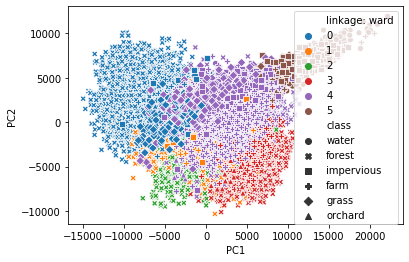

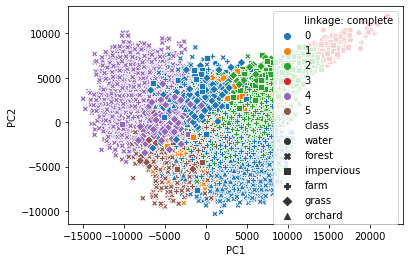

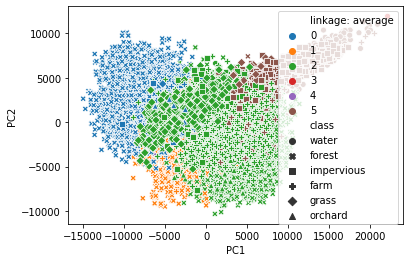

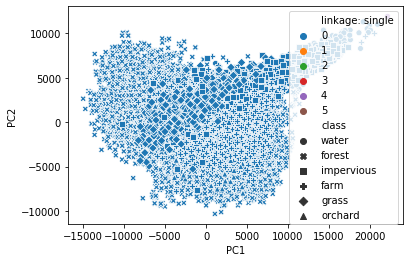

In [16]:
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
linkage=["ward", "complete", "average","single"]

for i in linkage:
    clustering = AgglomerativeClustering(n_clusters=6,linkage=i).fit(training_data)
    labels_pred = pd.Series(clustering.labels_ , name="linkage: "+i)
    ari= adjusted_rand_score(labels_true=labels_training,labels_pred=labels_pred)
    print("Type de linkage est: ",i,"  ARI score est: ",ari)
    plt.figure()
    scatterplot_pca(data=training_data,hue=labels_pred,style=labels_training)

    on peut dire ce modele n'est pas bonne pour notre jeu de donnees qui possede des inerties intra classe pas assez faible.

### K-means

-32571376033.971077


0.1055377649347357

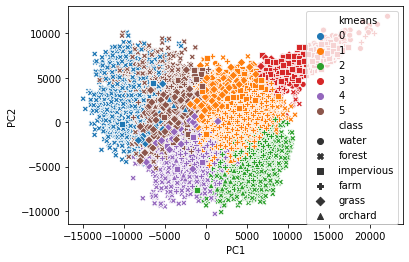

In [17]:
from sklearn.cluster import KMeans

sample_weight={}

kmeans = KMeans(n_clusters=6,n_jobs=-1)
kmeans.fit(training_data,sample_weight=None)
labels_pred = pd.Series(kmeans.labels_,name="kmeans")
print(kmeans.score(testing_data))
scatterplot_pca(data=training_data,hue=labels_pred,style=labels_training)
ari= adjusted_rand_score(labels_true=labels_training,labels_pred=labels_pred)
ari

## Supervisé (classification)

In [18]:
#retirer training set et validation set

# This cross-validation object is a variation of KFold that returns stratified folds.
# The folds are made by preserving the percentage of samples for each class.

from sklearn.model_selection import StratifiedKFold

skf=StratifiedKFold(n_splits=10,shuffle=True)
for train_idx,val_idx in skf.split(training_data,labels_training):
    print('Train: %s | Val: %s' % (train_idx, val_idx))
    print(" ")
    #print("train_x: ",training_data[train_idx])
    #print("train_y: ",labels_training[train_idx])
    #print("val_x:", training_data[val_idx])
    #print("val_y:", labels_training[val_idx])


Train: [    0     1     2 ... 10542 10543 10544] | Val: [   10    21    28 ... 10489 10501 10504]
 
Train: [    0     1     2 ... 10542 10543 10544] | Val: [   26    38    57 ... 10532 10533 10539]
 
Train: [    0     1     2 ... 10542 10543 10544] | Val: [    3    14    23 ... 10523 10535 10540]
 
Train: [    0     1     3 ... 10541 10542 10543] | Val: [    2     8    20 ... 10529 10537 10544]
 
Train: [    0     1     2 ... 10541 10543 10544] | Val: [   39    46    74 ... 10524 10534 10542]
 
Train: [    0     1     2 ... 10542 10543 10544] | Val: [   16    22    29 ... 10515 10526 10541]
 
Train: [    0     1     2 ... 10541 10542 10544] | Val: [    4     5     6 ... 10516 10536 10543]
 
Train: [    0     2     3 ... 10542 10543 10544] | Val: [    1     7     9 ... 10514 10521 10527]
 
Train: [    1     2     3 ... 10542 10543 10544] | Val: [    0    18    31 ... 10517 10519 10525]
 
Train: [    0     1     2 ... 10542 10543 10544] | Val: [   13    19    25 ... 10510 10520 10538]
 


### K nearest neighbors

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(n_jobs=-1)

hyper_param={
    "n_neighbors":range(3,6),
    "weights": ["uniform","distance"],
    "algorithm" :["ball_tree", "kd_tree", "brute"]   
}

grid_search = GridSearchCV(estimator= knn, param_grid= hyper_param, n_jobs= -1,cv= skf, return_train_score=True)

a=time()
grid_result = grid_search.fit(training_data,labels_training)
b=time()

b-a

298.8924996852875

In [40]:
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

Best: 0.968896 using {'algorithm': 'ball_tree', 'n_neighbors': 4, 'weights': 'distance'}
0.967947  with:   {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'uniform'}
0.968517  with:   {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}
0.967284  with:   {'algorithm': 'ball_tree', 'n_neighbors': 4, 'weights': 'uniform'}
0.968896  with:   {'algorithm': 'ball_tree', 'n_neighbors': 4, 'weights': 'distance'}
0.965482  with:   {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'}
0.966715  with:   {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}
0.967947  with:   {'algorithm': 'kd_tree', 'n_neighbors': 3, 'weights': 'uniform'}
0.968517  with:   {'algorithm': 'kd_tree', 'n_neighbors': 3, 'weights': 'distance'}
0.967284  with:   {'algorithm': 'kd_tree', 'n_neighbors': 4, 'weights': 'uniform'}
0.968896  with:   {'algorithm': 'kd_tree', 'n_neighbors': 4, 'weights': 'distance'}
0.965482  with:   {'algorithm': 'kd_tree', 'n_neighbors': 5, 'we

In [44]:
grid_result.cv_results_

{'mean_fit_time': array([0.07975526, 0.22564425, 0.20076916, 0.25585341, 0.2528255 ,
        0.27694445, 0.43623633, 0.34087191, 0.44459655, 0.43005927,
        0.4867202 , 0.41109343, 0.05637312, 0.04217205, 0.05786088,
        0.06547108, 0.08004987, 0.0697592 ]),
 'std_fit_time': array([0.00971861, 0.13075615, 0.11414207, 0.11281387, 0.08775286,
        0.07048651, 0.13370116, 0.10478246, 0.09794303, 0.16698674,
        0.09627323, 0.128684  , 0.0305179 , 0.0076416 , 0.02864819,
        0.02553714, 0.04624812, 0.02642088]),
 'mean_score_time': array([0.80243738, 2.22628202, 2.29632573, 2.61759968, 2.91193666,
        2.19039552, 2.40943482, 1.85559576, 2.59018269, 2.20367134,
        2.61795952, 2.20573871, 3.11849689, 0.60222743, 0.80414186,
        1.14347343, 1.12396269, 0.73213854]),
 'std_score_time': array([0.18365919, 1.14860539, 1.0976062 , 0.55201203, 0.42888373,
        0.41331998, 0.45550731, 0.26857503, 0.14731305, 0.51106785,
        0.83289537, 0.67917294, 1.95985435, 

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(n_jobs=-1)

hyper_param={
    "n_neighbors":range(2,10),
    "weights": ["distance"],
    "algorithm" :["ball_tree"]   
}

grid_search = GridSearchCV(estimator= knn, param_grid= hyper_param, n_jobs= -1,cv= skf, return_train_score=True)

a=time()
grid_result = grid_search.fit(training_data,labels_training)
b=time()

b-a

71.7756736278534

In [21]:
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

Best: 0.971077 using {'algorithm': 'ball_tree', 'n_neighbors': 4, 'weights': 'distance'}
0.969370  with:   {'algorithm': 'ball_tree', 'n_neighbors': 2, 'weights': 'distance'}
0.969465  with:   {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}
0.971077  with:   {'algorithm': 'ball_tree', 'n_neighbors': 4, 'weights': 'distance'}
0.969464  with:   {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}
0.968516  with:   {'algorithm': 'ball_tree', 'n_neighbors': 6, 'weights': 'distance'}
0.967283  with:   {'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'distance'}
0.966050  with:   {'algorithm': 'ball_tree', 'n_neighbors': 8, 'weights': 'distance'}
0.964438  with:   {'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}


In [22]:
knn_best = KNeighborsClassifier(
    n_neighbors=4, 
    weights= "distance", 
    algorithm="ball_tree",
    n_jobs=-1,
)
knn_best.fit(training_data,labels_training)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [23]:
labels_pred=pd.Series(knn_best.predict(testing_data),name="KNN")
knn_best.score(testing_data,labels_testing)

0.6233333333333333

In [64]:
%matplotlib inline

(<matplotlib.axes._subplots.AxesSubplot at 0x2a9800a5a48>,
 PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False))

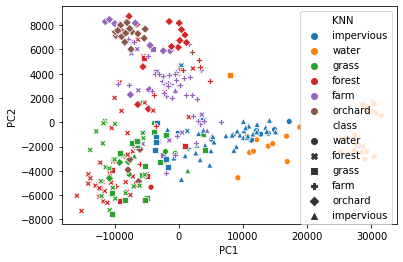

In [24]:
scatterplot_pca(data=testing_data,hue=labels_pred,style=labels_testing)

### Linear and Quadratic Discriminant Analysis

In [99]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda=LinearDiscriminantAnalysis()

hyper_param={
    "solver":["svd","lsqr","eigen"]  
}

grid_search = GridSearchCV(estimator= lda, param_grid= hyper_param, n_jobs= -1,cv= skf)

a=time()
grid_result = grid_search.fit(training_data,labels_training)
b=time()

b-a

2.148120880126953

In [100]:
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

Best: 0.881460 using {'solver': 'lsqr'}
0.881365  with:   {'solver': 'svd'}
0.881460  with:   {'solver': 'lsqr'}
0.881460  with:   {'solver': 'eigen'}


In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda=LinearDiscriminantAnalysis(solver="lsqr")
lda.fit(training_data,labels_training)
lda.score(testing_data,labels_testing)

0.5933333333333334

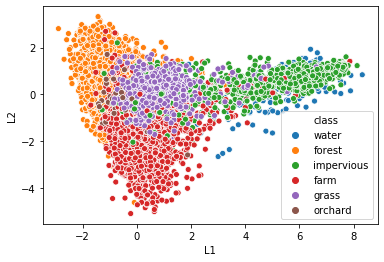

In [110]:
# sns.scatterplot(x=training_lda["L1"],y= training_lda["L2"], hue=labels_training)

In [26]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda=QuadraticDiscriminantAnalysis()
training_qda= qda.fit(training_data,labels_training)

In [27]:
qda.score(testing_data,labels_testing)

0.5533333333333333

In [28]:
np.set_printoptions(suppress=True)
pd.set_option('float_format', lambda x: '%.3f' % x)
pd.DataFrame(qda.predict_proba(testing_data),columns=qda.classes_)

farm  forest  grass  impervious  orchard  water
0   0.000   0.000  0.001       0.000    0.000  0.999
1   0.000   0.000  0.000       0.262    0.000  0.738
2   0.540   0.000  0.002       0.022    0.000  0.436
3   0.000   0.000  0.000       0.000    0.000  1.000
4   0.000   0.000  0.000       0.027    0.000  0.973
..    ...     ...    ...         ...      ...    ...
295 0.000   0.000  0.000       0.998    0.000  0.002
296 0.000   0.000  0.053       0.000    0.000  0.947
297 0.000   0.000  0.000       0.981    0.000  0.019
298 0.000   0.000  0.010       0.001    0.000  0.990
299 0.000   0.000  1.000       0.000    0.000  0.000

[300 rows x 6 columns]

### Naive Bayes

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

gnb= GaussianNB()
print(cross_val_score(gnb,training_data,labels_training,cv=skf))
gnb.fit(training_data,labels_training)
gnb.score(testing_data,labels_testing)

[0.91184834 0.91090047 0.89668246 0.89668246 0.89668246 0.90037951
 0.89848197 0.91555977 0.89184061 0.91745731]


0.62

In [33]:
gnb= GaussianNB(priors=np.ones(6)/6)
print(cross_val_score(gnb,training_data,labels_training,cv=skf))
gnb.fit(training_data,labels_training)
labels_pred=pd.Series(gnb.predict(testing_data),name="GNB equal proba")
gnb.score(testing_data,labels_testing)


[0.8521327  0.86350711 0.85781991 0.85971564 0.86161137 0.87096774
 0.87571157 0.86242884 0.87476281 0.85958254]


0.6466666666666666

(<matplotlib.axes._subplots.AxesSubplot at 0x1f38aa7d4c8>,
 PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False))

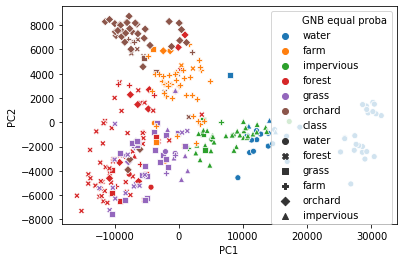

In [129]:
scatterplot_pca(data=testing_data,hue=labels_pred,style=labels_testing)

### Tree

#### decisiontree + adaboost

In [34]:
from sklearn.tree import DecisionTreeClassifier

dtc= DecisionTreeClassifier()
print(cross_val_score(dtc,training_data,labels_training,cv=skf))
dtc.fit(training_data,labels_training)
dtc.score(testing_data,labels_testing)

[0.88530806 0.86729858 0.88056872 0.87109005 0.86919431 0.87760911
 0.86812144 0.87381404 0.87571157 0.87571157]


0.5266666666666666

In [35]:
from sklearn.ensemble import AdaBoostClassifier
dtc= DecisionTreeClassifier()
dtc_ada = AdaBoostClassifier(dtc)
dtc_ada.fit(training_data,labels_training)
dtc_ada.score(testing_data,labels_testing)

0.5333333333333333

In [36]:
dtc= DecisionTreeClassifier(class_weight="balanced")
print(cross_val_score(dtc,training_data,labels_training,cv=skf))
dtc.fit(training_data,labels_training)
dtc.score(testing_data,labels_testing)

[0.85687204 0.87109005 0.86919431 0.87393365 0.88720379 0.87286528
 0.87666034 0.88804554 0.88899431 0.87191651]


0.5466666666666666

In [37]:
from sklearn.ensemble import AdaBoostClassifier
dtc= DecisionTreeClassifier(class_weight="balanced")
dtc_ada = AdaBoostClassifier(dtc)
dtc_ada.fit(training_data,labels_training)
dtc_ada.score(testing_data,labels_testing)

0.5

In [38]:
from sklearn.ensemble import AdaBoostClassifier
dtc_ada = AdaBoostClassifier()
dtc_ada.fit(training_data,labels_training)
dtc_ada.score(testing_data,labels_testing)

0.39

#### random forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

rfc= RandomForestClassifier(oob_score=True)
rfc.fit(training_data,labels_training)
print(rfc.oob_score_)
rfc.score(testing_data,labels_testing)

0.932764343290659


0.61

In [40]:
rfc= RandomForestClassifier(oob_score=True,class_weight="balanced")
rfc.fit(training_data,labels_training)
print(rfc.oob_score_)
rfc.score(testing_data,labels_testing)

0.9234708392603129


0.5633333333333334

In [186]:
rfc= RandomForestClassifier(oob_score=True,class_weight="balanced",n_jobs=-1)
hyper_param={
    "n_estimators":[10,20,50,100] ,
}

grid_search = GridSearchCV(estimator= rfc,param_grid= hyper_param, n_jobs= -1)

a=time()
grid_result = grid_search.fit(training_data,labels_training)
b=time()

b-a

6.012024402618408

In [188]:
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

Best: 0.918824 using {'n_estimators': 100}
0.907729  with:   {'n_estimators': 10}
0.911996  with:   {'n_estimators': 20}
0.917781  with:   {'n_estimators': 50}
0.918824  with:   {'n_estimators': 100}


In [41]:
rfc= RandomForestClassifier(n_estimators=100,oob_score=True,class_weight="balanced",n_jobs=-1,max_samples=200)
rfc.fit(training_data,labels_training)
print(rfc.oob_score_)
rfc.score(testing_data,labels_testing)

0.8091038406827881


0.38666666666666666

In [42]:
class_weight =(10000/training_original["class"].value_counts()).to_dict()
rfc= RandomForestClassifier(n_estimators=100,oob_score=True,class_weight=class_weight,n_jobs=-1)
rfc.fit(training_data,labels_training)
print(rfc.oob_score_)
rfc.score(testing_data,labels_testing)

0.9243243243243243


0.5566666666666666

1000 fois repetition de forest avec des donnees aleatoires qui possede le nombre identique de individu dans chaque classe

In [43]:
from random import sample

def n_in_each_class(X,y,n=20,boucle=100):
    id_list=[]
    id=[]
    for j in range(boucle):
        for i in y.unique():
            id= id + sample(y[y==i].index.tolist(),n)
        id_list.append(id)
    return id_list
    
nb_sample_in_each_class = 2
nb_trees_in_each_forest =10
nb_boucle=100

oob_list_rf=[]
pred_proba_rf=[]
id_list= n_in_each_class(training_data,labels_training, nb_sample_in_each_class,nb_boucle)


for i in range(nb_boucle):
    x_train, y_train= training_data.iloc[id_list[i]],labels_training.iloc[id_list[i]]
    rfc= RandomForestClassifier(
        n_estimators=nb_trees_in_each_forest,
        n_jobs=-1
    )
    rfc.fit(x_train,y_train)
    pred_proba_rf.append(rfc.predict_proba(testing_data))
    
pred_proba_rf_np= np.array(pred_proba_rf)
pred=pred_proba_rf_np.sum(axis=0)

result=[]
for i in range(300):
    result.append(rfc.classes_[np.argmax(pred[i,:])])
    
score= np.mean(result==labels_testing)
score    

0.62

### Support Vector Machines

In [44]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc= SVC()
hyper_param={
#     "kernel":[
#         "linear","poly",
#         "rbf","sigmod"] ,
#     "decision_function_shape":["ovo","ovr"] 
}

grid_search = GridSearchCV(estimator= svc, param_grid= hyper_param, n_jobs= -1,cv= skf)

a=time()
grid_result = grid_search.fit(training_data,labels_training)
b=time()

print("time:  ",b-a)

print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))
svc.fit(training_data,labels_training)
svc.score(testing_data,labels_testing)

time:   3.551528215408325
Best: 0.958084 using {}
0.958084  with:   {}


0.56

In [45]:
svc= SVC()
svc.fit(training_data,labels_training)
svc.score(testing_data,labels_testing)

0.56